In [86]:
import json

with open('issues.json', 'r', encoding='utf-8') as file:
    issues_data = json.load(file)

def print_schema(d, indent=0):
    if isinstance(d, dict):
        for key, value in d.items():
            print('  ' * indent + str(key))  
            print_schema(value, indent + 1)
    elif isinstance(d, list):
        if len(d) > 0:
            print('  ' * indent + "[list]")
            print_schema(d[0], indent + 1)

print("Schema of the JSON file:")
print_schema(issues_data)

Schema of the JSON file:
[list]
  url
  repository_url
  labels_url
  comments_url
  events_url
  html_url
  id
  node_id
  number
  title
  user
    login
    id
    node_id
    avatar_url
    gravatar_id
    url
    html_url
    followers_url
    following_url
    gists_url
    starred_url
    subscriptions_url
    organizations_url
    repos_url
    events_url
    received_events_url
    type
    site_admin
  labels
    [list]
      id
      node_id
      url
      name
      color
      default
      description
  state
  locked
  assignee
  assignees
  milestone
  comments
  created_at
  updated_at
  closed_at
  author_association
  active_lock_reason
  draft
  pull_request
    url
    html_url
    diff_url
    patch_url
    merged_at
  body
  closed_by
  reactions
    url
    total_count
    +1
    -1
    laugh
    hooray
    confused
    heart
    rocket
    eyes
  timeline_url
  performed_via_github_app
  state_reason


In [87]:
fields_to_remove = [
    'url', 'repository_url', 'labels_url', 'comments_url', 'events_url', 'html_url', 'node_id',
    'avatar_url', 'gravatar_id', 'gists_url'
]

def remove_fields(d):
    if isinstance(d, dict):
        for field in fields_to_remove:
            d.pop(field, None)
        
        for key, value in list(d.items()):
            if isinstance(value, dict):
                remove_fields(value)
            elif isinstance(value, list):
                for item in value:
                    remove_fields(item)

    elif isinstance(d, list):
        for item in d:
            remove_fields(item)

remove_fields(issues_data)


print("Unwanted fields removed")

Unwanted fields removed


In [88]:
issue_count = len(issues_data)
print(f"Number of issues in the data: {issue_count}")

Number of issues in the data: 52651


In [89]:
from datetime import datetime

sorted_issues = sorted(issues_data, key=lambda x: datetime.strptime(x['updated_at'], "%Y-%m-%dT%H:%M:%SZ"), reverse=True) #by ChatGPT
last_500_issues = sorted_issues[:500]

print(f"Number of issues after filtering: {len(last_500_issues)}")

Number of issues after filtering: 500


In [90]:
import pandas as pd

# Creating the user dataframe
user_columns = [
    'login', 'id', 'Followers', 'Following', 'Starred Repos', 'Repositories', 'Organizations',
    'Followers URL', 'Following URL', 'Starred URL', 'Subscriptions URL', 'Organizations URL', 
    'Repos URL', 'Received Events URL', 'Watch Events', 'Fork Events', 'Pull Request Events', 
    'Issue Events', 'Push Events'
]
user_dataframe = pd.DataFrame(columns=user_columns)

# Creating the labels dataframe
labels_dataframe = pd.DataFrame(columns=['id', 'name', 'color', 'default', 'description'])

print("User DataFrame:")
print(user_dataframe)

print("\nLabels DataFrame:")
print(labels_dataframe)

User DataFrame:
Empty DataFrame
Columns: [login, id, Followers, Following, Starred Repos, Repositories, Organizations, Followers URL, Following URL, Starred URL, Subscriptions URL, Organizations URL, Repos URL, Received Events URL, Watch Events, Fork Events, Pull Request Events, Issue Events, Push Events]
Index: []

Labels DataFrame:
Empty DataFrame
Columns: [id, name, color, default, description]
Index: []


In [91]:
from tqdm import tqdm 

processed_issues = []
user_rows = [] 
labels_rows = []

for issue in tqdm(last_500_issues):
    user_id = issue['user']['id']
    issue['user_id'] = user_id

    # Insert user data into user_dataframe
    user_data = {
        'login': issue.get('user', {}).get('login', None),
        'id': user_id,
        'Followers URL': issue.get('user', {}).get('followers_url', None),
        'Following URL': issue.get('user', {}).get('following_url', None),
        'Starred URL': issue.get('user', {}).get('starred_url', None),
        'Subscriptions URL': issue.get('user', {}).get('subscriptions_url', None),
        'Organizations URL': issue.get('user', {}).get('organizations_url', None),
        'Repos URL': issue.get('user', {}).get('repos_url', None),
        'Received Events URL': issue.get('user', {}).get('received_events_url', None),
        'Watch Events': None,  
        'Followers': None,  
        'Following': None,
        'Starred Repos': None,
        'Repositories': None,
        'Organizations': None,
        'Fork Events': None,
        'Pull Request Events': None,
        'Issue Events': None,
        'Push Events': None
    }
    user_rows.append(user_data)
    issue.pop('user', None)

    if 'closed_by' in issue and issue['closed_by']:
        closed_by_id = issue['closed_by']['id']
        issue['closed_by_id'] = closed_by_id

        # Insert closed_by user data into user_dataframe
        closed_by_data = {
            'login': issue['closed_by'].get('login', None),
            'id': closed_by_id,
            'Followers': None,
            'Following': None,
            'Starred Repos': None,
            'Repositories': None,
            'Organizations': None,
            'Followers URL': issue['closed_by'].get('followers_url', None),
            'Following URL': issue['closed_by'].get('following_url', None),
            'Starred URL': issue['closed_by'].get('starred_url', None),
            'Subscriptions URL': issue['closed_by'].get('subscriptions_url', None),
            'Organizations URL': issue['closed_by'].get('organizations_url', None),
            'Repos URL': issue['closed_by'].get('repos_url', None),
            'Received Events URL': issue['closed_by'].get('received_events_url', None),
            'Watch Events': None,
            'Fork Events': None,
            'Pull Request Events': None,
            'Issue Events': None,
            'Push Events': None
        }
        user_rows.append(closed_by_data)
        issue.pop('closed_by', None)

    if 'labels' in issue:
        label_ids = [label['id'] for label in issue['labels']]
        issue['label_ids'] = label_ids
        
        # Insert label data into labels_dataframe
        for label in issue.get('labels', []):
            label_data = {
                'id': label['id'],
                'name': label.get('name'),
                'color': label.get('color'),
                'default': label.get('default'),
                'description': label.get('description')
            }
            labels_rows.append(label_data)

        issue.pop('labels', None)  


    # Flatten the reactions and pull_request fields
    if 'reactions' in issue:
        reactions = issue.pop('reactions')
        issue['reactions_total_count'] = reactions['total_count']
        issue['reactions_plus1'] = reactions['+1']
        issue['reactions_minus1'] = reactions['-1']
        issue['reactions_laugh'] = reactions['laugh']
        issue['reactions_hooray'] = reactions['hooray']
        issue['reactions_confused'] = reactions['confused']
        issue['reactions_heart'] = reactions['heart']
        issue['reactions_rocket'] = reactions['rocket']
        issue['reactions_eyes'] = reactions['eyes']

    if 'pull_request' in issue:
        pull_request = issue.pop('pull_request')
        issue['pull_request_diff_url'] = pull_request['diff_url']
        issue['pull_request_patch_url'] = pull_request['patch_url']
        issue['pull_request_merged_at'] = pull_request['merged_at']

    processed_issues.append(issue)


with open('processed_issues.json', 'w', encoding='utf-8') as file:
    json.dump(processed_issues, file, ensure_ascii=False, indent=4)

user_dataframe = pd.concat([user_dataframe, pd.DataFrame(user_rows)], ignore_index=True)
labels_dataframe = pd.concat([labels_dataframe, pd.DataFrame(labels_rows)], ignore_index=True)

print(f"User DataFrame: {user_dataframe.shape}")
print(user_dataframe[['login', 'id', 'Followers', 'Following', 'Followers URL']].head())

print(f"\nLabels DataFrame: {labels_dataframe.shape}")
print(labels_dataframe.head())

100%|██████████| 500/500 [00:00<00:00, 75816.20it/s]

User DataFrame: (855, 19)
       login        id Followers Following   
0  jhawthorn    131752      None      None  \
1  jhawthorn    131752      None      None   
2     jayqui  10286362      None      None   
3        dhh      2741      None      None   
4       zzak    277819      None      None   

                                      Followers URL  
0  https://api.github.com/users/jhawthorn/followers  
1  https://api.github.com/users/jhawthorn/followers  
2     https://api.github.com/users/jayqui/followers  
3        https://api.github.com/users/dhh/followers  
4       https://api.github.com/users/zzak/followers  

Labels DataFrame: (646, 5)
          id           name   color default description
0     107190    activemodel  00E5FF   False        None
1     107194  activesupport  FC9300   False        None
2     107191   activerecord  0b02e1   False        None
3  664533972  activestorage  bfd4f2   False        None
4     150377           docs  02d7e1   False        None


In [92]:
user_dataframe = user_dataframe.drop_duplicates(subset='id', keep='first')
labels_dataframe = labels_dataframe.drop_duplicates(subset='id', keep='first')

print("User DataFrame shape after dropping duplicates:")
print(user_dataframe.shape)

print("\nLabels DataFrame shape after dropping duplicates:")
print(labels_dataframe.shape)

User DataFrame shape after dropping duplicates:
(309, 19)

Labels DataFrame shape after dropping duplicates:
(33, 5)


In [93]:
user_dataframe_output_file = "users_data.json"
user_dataframe.to_json(user_dataframe_output_file, orient='records')
print(f"User DataFrame saved to {user_dataframe_output_file}")

labels_dataframe_output_file = "labels_data.json"
labels_dataframe.to_json(labels_dataframe_output_file, orient='records')
print(f"Labels DataFrame saved to {labels_dataframe_output_file}")

User DataFrame saved to users_data.json
Labels DataFrame saved to labels_data.json


# How do the number of issues evolve over time?

In [94]:
!pip install plotly > log

In [95]:
import plotly.express as px

issues_df = pd.DataFrame(last_500_issues)
issues_df['created_at'] = pd.to_datetime(issues_df['created_at'])
issues_df['year'] = issues_df['created_at'].dt.year
issues_df['month'] = issues_df['created_at'].dt.month
issues_df['quarter'] = issues_df['created_at'].dt.quarter
issues_df['created_at']=issues_df['created_at'].dt.date
issues_by_date = issues_df.groupby('created_at').size().reset_index(name='issue_count')

fig = px.line(issues_by_date, x='created_at', y='issue_count', 
              title='Number of Issues Over Time',
              labels={'created_at': 'Date', 'issue_count': 'Number of Issues Created'})

fig.show()

In [96]:
issues_by_year = issues_df.groupby('year').size().reset_index(name='issue_count')

fig = px.line(issues_by_year, x='year', y='issue_count', 
              title='Number of Issues Over Years',
              labels={'year': 'Year', 'issue_count': 'Number of Issues Created'})

fig.show()

From 2012 to 2016, the number of issues went up and down. In 2012, there were 3 issues, which increased to 7 in 2013. However, it dropped to 0 in 2014, then rose again to 2 in 2015, and returned to 0 in 2016.

Starting from 2017, the number of issues has consistently increased. There was 1 issue in 2017, 5 in 2018, 5 in 2019, 7 in 2020, the numbers continued to rise: 9 in 2021, 15 in 2022, 44 in 2023 and 402 in 2024.

Are there any periods in which we get more issues?# 

In [97]:
issues_by_month = issues_df.groupby('month').size().reset_index(name='issue_count')

fig = px.line(issues_by_month, x='month', y='issue_count', 
               title='Number of Issues by Month',
               labels={'month': 'Month', 'issue_count': 'Number of Issues'})
fig.show()

The number of issues changes each month. In January, there are about 15 issues which increases in February and March. Then drops in April returning to 15 issues. The highest number of issues occurs in September with 252 issues. After September, the number decreases. October having the lowest count (only 7 issues). This shows that more issues are created in the middle of the year, especially in August (72 issues) and September. While the numbers are lowest in October and at the beginning and end of the year.

In [98]:
issues_by_quarter = issues_df.groupby('quarter').size().reset_index(name='issue_count')

fig2 = px.line(issues_by_quarter, x='quarter', y='issue_count', 
               title='Number of Issues by Quarter',
               labels={'quarter': 'Quarter', 'issue_count': 'Number of Issues'})
fig2.show()

The number of issues also changes across the quarters of the year. In the first quarter (January to March) there are around 51 issues. The second quarter (April to June) the number increase to 66 issues. In the third quarter (July to September) the number of issues peaks at about 346. Finally, in the fourth quarter (October to December) the number decreases to its minimum value around 37 issues.

# Is there anyone who reports more issues than others?

In [99]:
unique_users = issues_df['user_id'].unique()
print(f"Number of unique Users: {len(unique_users)}")

issues_by_user = issues_df.groupby('user_id').size().reset_index(name='issue_count')
issues_by_user = issues_by_user.sort_values(by='issue_count', ascending=False)
issues_by_user['user_id'] = issues_by_user['user_id'].astype(str)

print("\nList of Users and the Number of Issues Reported:")
print(issues_by_user)

fig = px.bar(issues_by_user, x='user_id', y='issue_count', 
             title='Number of Issues Reported by Each User',
             labels={'user': 'User', 'issue_count': 'Number of Issues Reported'},
             text='issue_count')

fig.show()

statistics = issues_by_user.groupby('issue_count').size().reset_index(name='user_count')

print("\nNumber of Users with Specific Issue Counts")
print(statistics)

fig = px.bar(statistics, x='issue_count', y='user_count', 
             title='How Many Users Reported Each Number of Issues',
             labels={'user': 'User', 'issue_count': 'Number of Issues Reported'},
             text='issue_count')

fig.show()

Number of unique Users: 297

List of Users and the Number of Issues Reported:
       user_id  issue_count
7         2741           25
33       28561           16
82      277819           13
198    5657035           12
71      162976           11
..         ...          ...
117     727781            1
118     740289            1
122     796212            1
123     809410            1
296  181850106            1

[297 rows x 2 columns]



Number of Users with Specific Issue Counts
    issue_count  user_count
0             1         233
1             2          34
2             3          10
3             4           7
4             5           1
5             7           2
6             8           1
7             9           3
8            10           1
9            11           1
10           12           1
11           13           1
12           16           1
13           25           1


The results indicate that most users report only 1 issue. Out of 297 unique users, 233 have submitted just 1 issue. A smaller group of 34 users reported 2 issues each, and only 10 users reported 3 issues. As the number of issues increases, fewer users are involved. For example, only 1 user reported 10 issues, while the user with the most issues submitted a total of 25.

This shows that the majority of users are occasional reporters, while only a small number of users consistently report a higher number of issues.

# What is the most popular category (label)? 

In [100]:
issues_df_expanded = issues_df.explode('label_ids')

label_counts = issues_df_expanded.groupby('label_ids').size().reset_index(name='labels_count')
print(label_counts.shape)

label_counts_with_names = label_counts.merge(labels_dataframe[['id', 'name']], left_on='label_ids', right_on='id')
print(label_counts_with_names.shape)

label_counts_with_names = label_counts_with_names.sort_values(by='labels_count', ascending=False)

most_popular_label = label_counts_with_names.iloc[0]
print(f"The most popular label is '{most_popular_label['name']}' with {most_popular_label['labels_count']} occurrences.")

print(label_counts_with_names[['name', 'labels_count']])

(33, 2)
(33, 4)
The most popular label is 'activerecord' with 140 occurrences.
                       name  labels_count
4              activerecord           140
6                  railties           103
10                     docs            69
2                actionpack            51
5             activesupport            42
11               actionview            23
18  With reproduction steps            23
13                    stale            21
24            activestorage            21
14              attached PR            17
3               activemodel            17
27                    ready            16
17                activejob            14
28            actionmailbox            13
29               actiontext            12
21              actioncable            11
1              actionmailer             8
19                   pinned             8
15               PostgreSQL             7
9         third party issue             6
32         rails foundation            

# Suggest and answer a question that you came up with yourself.

### How does a user's profile (like their followers, who they follow, and group memberships) impact the results of their reported issues? This includes how quickly issues are resolved, if they're resolved, and how much others interact with them?

**closure time and resolution success**

In [101]:
import requests

def fetch_github_user_data(user_data):
    try:
        followers = requests.get(user_data['Followers URL']).json()
        followings = requests.get(user_data['Following URL'].replace('{/other_user}', '')).json()
        starred = requests.get(user_data['Starred URL'].replace('{/owner}{/repo}', '')).json()
        repos = requests.get(user_data['Repos URL']).json()
        organizations = requests.get(user_data['Organizations URL']).json()

        # Extract IDs from the responses
        user_data['Followers'] = [follower['id'] for follower in followers] if isinstance(followers, list) else None
        user_data['Following'] = [following['id'] for following in followings] if isinstance(followings, list) else None
        user_data['Starred Repos'] = [repo['id'] for repo in starred] if isinstance(starred, list) else None
        user_data['Repositories'] = [repo['id'] for repo in repos] if isinstance(repos, list) else None
        user_data['Organizations'] = [org['id'] for org in organizations] if isinstance(organizations, list) else None

    except Exception as e:
        print(f"Error fetching data for user {user_data.get('login')}: {e}")

    return user_data


user_dataframe = user_dataframe.apply(fetch_github_user_data, axis=1)
print(user_dataframe.shape)
user_dataframe[['login', 'Followers', 'Following', 'Starred Repos', 'Repositories', 'Organizations']].head()


In [79]:
user_dataframe_output_file = "users_data.json"
user_dataframe.to_json(user_dataframe_output_file, orient='records')
print(f"User DataFrame saved to {user_dataframe_output_file}")

User DataFrame saved to users_data.json


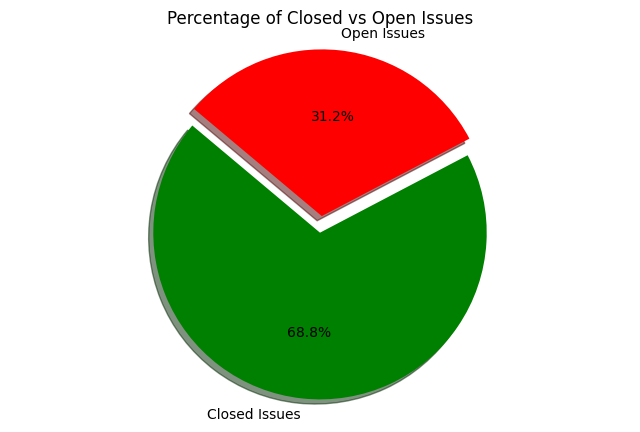

In [80]:
import matplotlib.pyplot as plt

issues_df['created_at'] = pd.to_datetime(issues_df['created_at']).dt.tz_localize(None)
issues_df['closed_at'] = pd.to_datetime(issues_df['closed_at'], errors='coerce').dt.tz_localize(None)

issues_df['closure_time'] = (issues_df['closed_at'] - issues_df['created_at']).dt.days

closed_issues_count = issues_df[issues_df['closed_at'].notnull()].shape[0]
total_issues_count = issues_df.shape[0]
open_issues_count = total_issues_count - closed_issues_count

labels = 'Closed Issues', 'Open Issues'
sizes = [closed_issues_count, open_issues_count]
colors = ['green', 'red']
explode = (0.1, 0)  

plt.figure(figsize=(8, 5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal') 
plt.title('Percentage of Closed vs Open Issues')
plt.show()

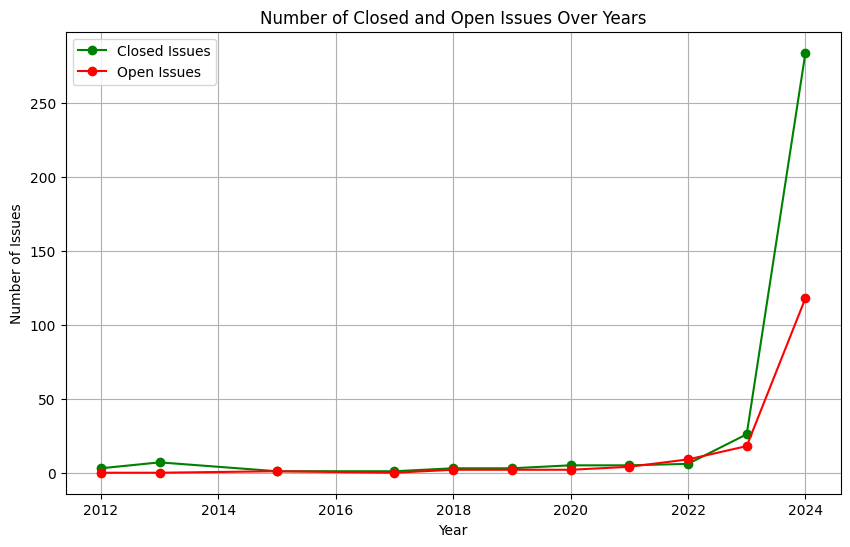

In [81]:
issues_df['issue_status'] = issues_df['closed_at'].apply(lambda x: 'closed' if pd.notnull(x) else 'open')

yearly_issues = issues_df.groupby(['year', 'issue_status']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
for status, color in zip(['closed', 'open'], ['green', 'red']):
    plt.plot(yearly_issues.index, yearly_issues[status], marker='o', color=color, label=f'{status.capitalize()} Issues')

plt.title('Number of Closed and Open Issues Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Issues')
plt.legend()
plt.grid(True)
plt.show()

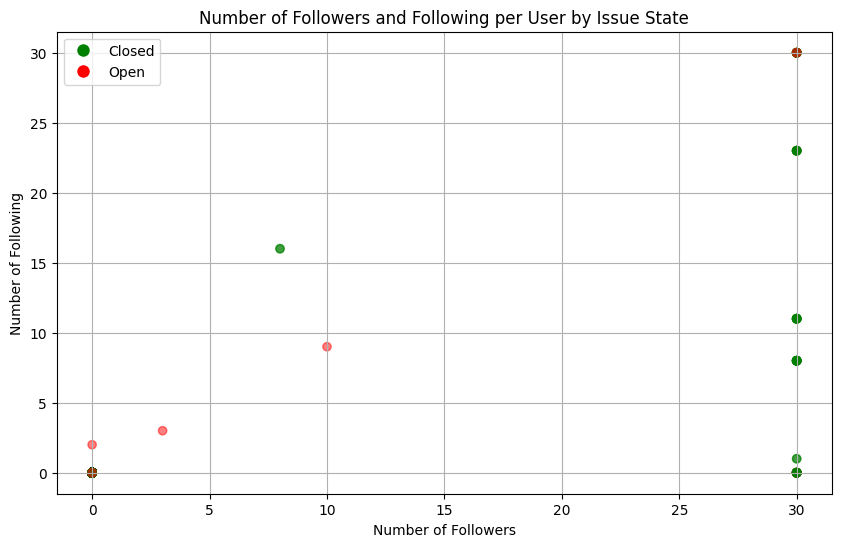

In [82]:
combined_df = issues_df.merge(user_dataframe, left_on='user_id', right_on='id', how='left')

combined_df['num_followers'] = combined_df['Followers'].apply(lambda x: len(x) if isinstance(x, list) else 0)
combined_df['num_following'] = combined_df['Following'].apply(lambda x: len(x) if isinstance(x, list) else 0)

colors = combined_df['state'].map({'closed': 'green', 'open': 'red'})

#############################################################
#                         By ChatGPT                        #
#############################################################

plt.figure(figsize=(10, 6))
plt.scatter(combined_df['num_followers'], combined_df['num_following'], c=colors, alpha=0.5)
plt.title('Number of Followers and Following per User by Issue State')
plt.xlabel('Number of Followers')
plt.ylabel('Number of Following')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Closed'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Open')])
plt.grid(True)
plt.show()

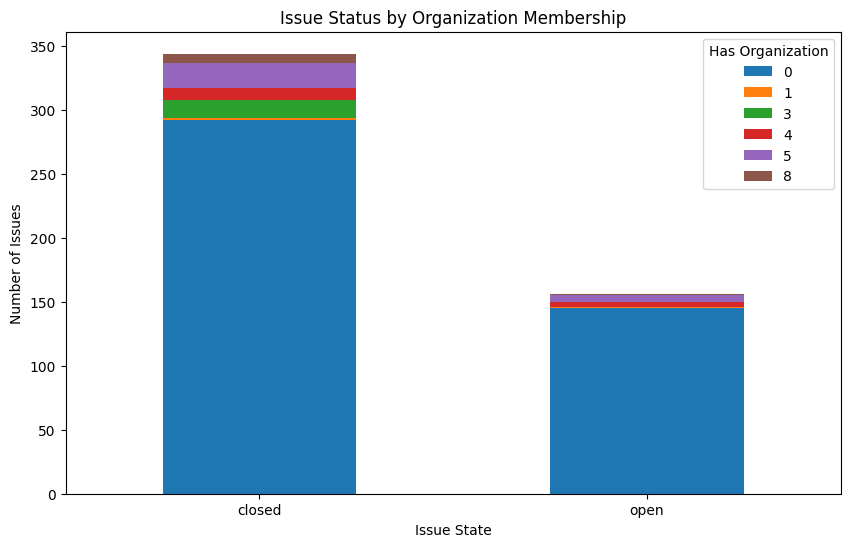

In [83]:
combined_df['num_organizations'] = combined_df['Organizations'].apply(lambda x: len(x) if isinstance(x, list) else 0)
org_issue_counts = combined_df.groupby(['state', 'num_organizations']).size().unstack(fill_value=0)

org_issue_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Issue Status by Organization Membership')
plt.xlabel('Issue State')
plt.ylabel('Number of Issues')
plt.xticks(rotation=0)  
plt.legend(title='Has Organization')
plt.show()

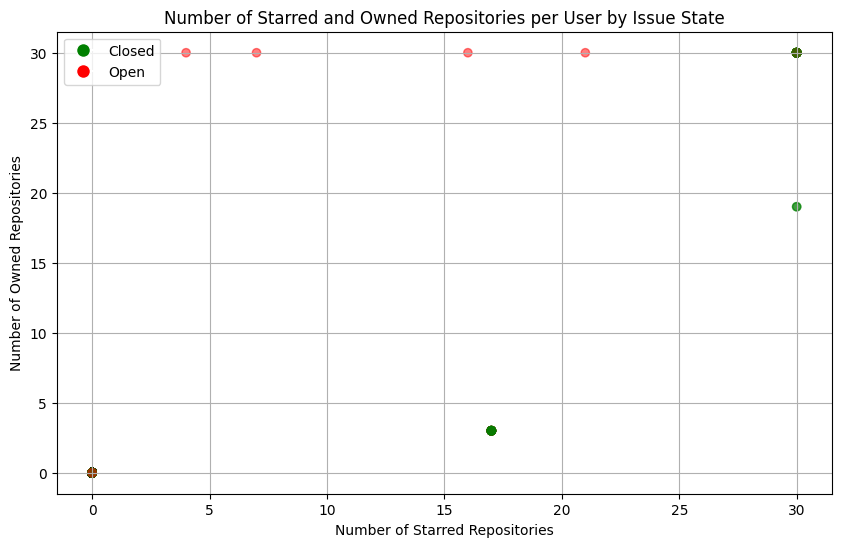

In [84]:
combined_df['num_starred_repos'] = combined_df['Starred Repos'].apply(lambda x: len(x) if isinstance(x, list) else 0)
combined_df['num_repositories'] = combined_df['Repositories'].apply(lambda x: len(x) if isinstance(x, list) else 0)

plt.figure(figsize=(10, 6))
plt.scatter(combined_df['num_starred_repos'], combined_df['num_repositories'], c=colors, alpha=0.5)
plt.title('Number of Starred and Owned Repositories per User by Issue State')
plt.xlabel('Number of Starred Repositories')
plt.ylabel('Number of Owned Repositories')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Closed'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Open')])
plt.grid(True)
plt.show()

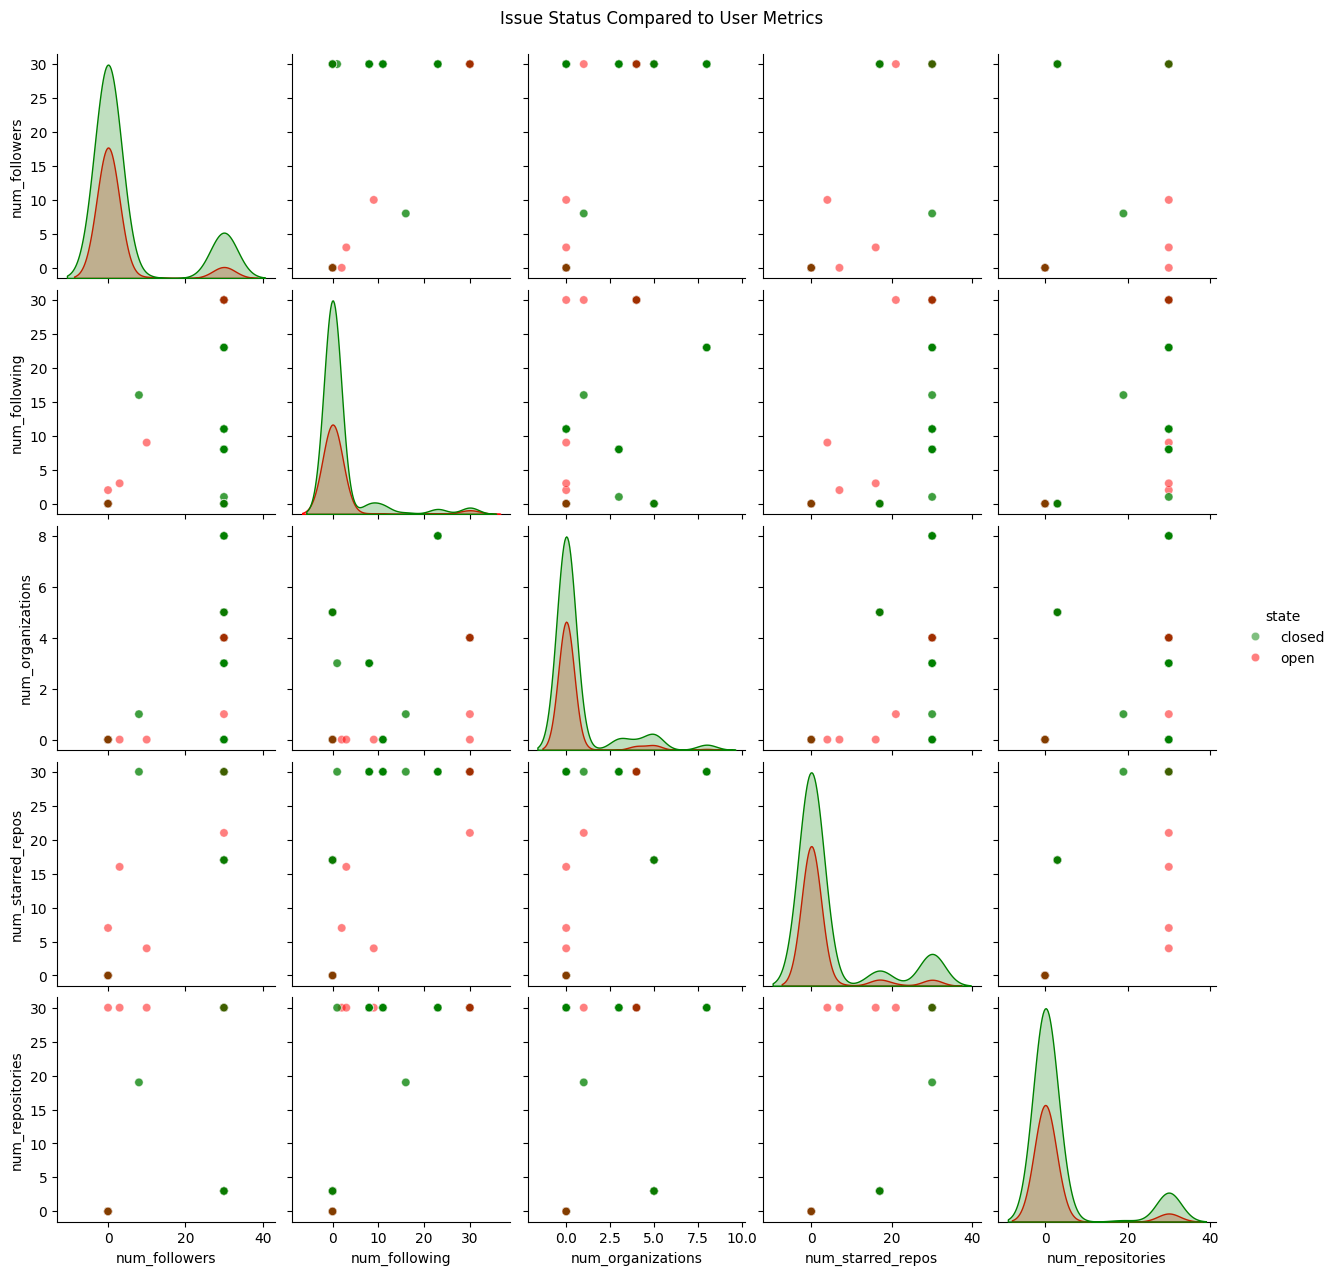

In [85]:
import seaborn as sns

plot_data = combined_df[['num_followers', 'num_following', 'num_organizations', 'num_starred_repos', 'num_repositories', 'state']]

palette = {'open': 'red', 'closed': 'green'}

sns.pairplot(plot_data, hue='state', vars=['num_followers', 'num_following', 'num_organizations', 'num_starred_repos', 'num_repositories'],
             palette=palette, plot_kws={'alpha': 0.5})

plt.suptitle('Issue Status Compared to User Metrics', y=1.02)
plt.show()

Being more active and connected on GitHub could increase the chances of your issues being successfully resolved.


In [51]:
!pip install statsmodels > log

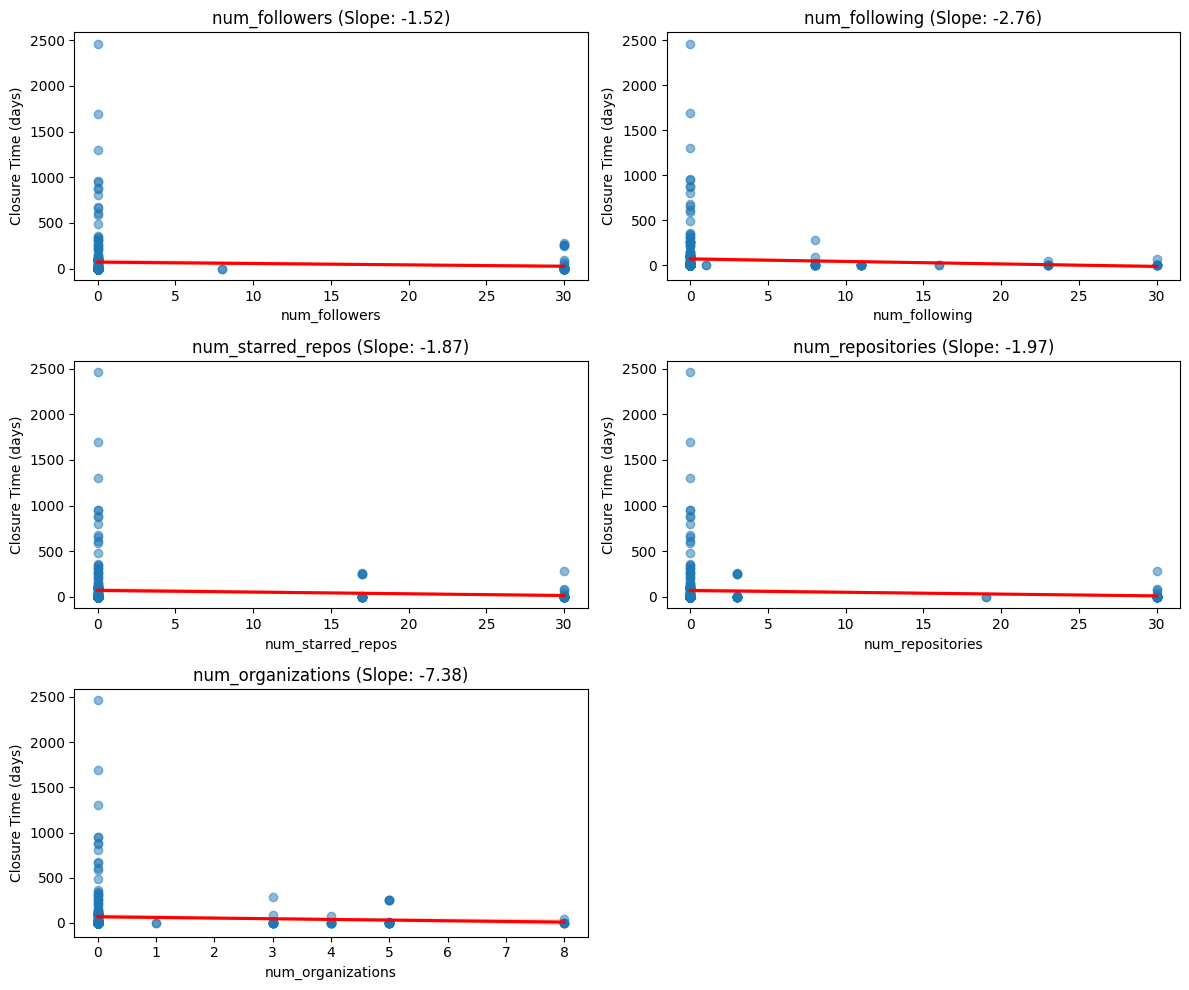

In [52]:
import statsmodels.api as sm

closed_issues = combined_df[combined_df['state'] == 'closed']

plt.figure(figsize=(12, 10))

user_metrics = ['num_followers', 'num_following', 'num_starred_repos', 'num_repositories', 'num_organizations']
slopes = {}

#############################################################
#        Refined By ChatGPT to add slopes calculation       #
#############################################################
for i, metric in enumerate(user_metrics):
    plt.subplot(3, 2, i+1)
    X = sm.add_constant(closed_issues[metric])
    y = closed_issues['closure_time']
    
    model = sm.OLS(y, X, missing='drop').fit() 
    
    slopes[metric] = model.params[1]  
    
    sns.regplot(x=metric, y='closure_time', data=closed_issues, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'{metric} (Slope: {slopes[metric]:.2f})')
    plt.xlabel(metric)
    plt.ylabel('Closure Time (days)')

plt.tight_layout()
plt.show()

In [53]:
print("Slopes of the regression lines:")
for metric, slope in slopes.items():
    print(f"{metric}: {slope:.4f}")

Slopes of the regression lines:
num_followers: -1.5195
num_following: -2.7615
num_starred_repos: -1.8698
num_repositories: -1.9705
num_organizations: -7.3772


Active and well-connected users in the GitHub community not only have a higher chance of issue resolution but also a quicker resolutions.

**community engagement**

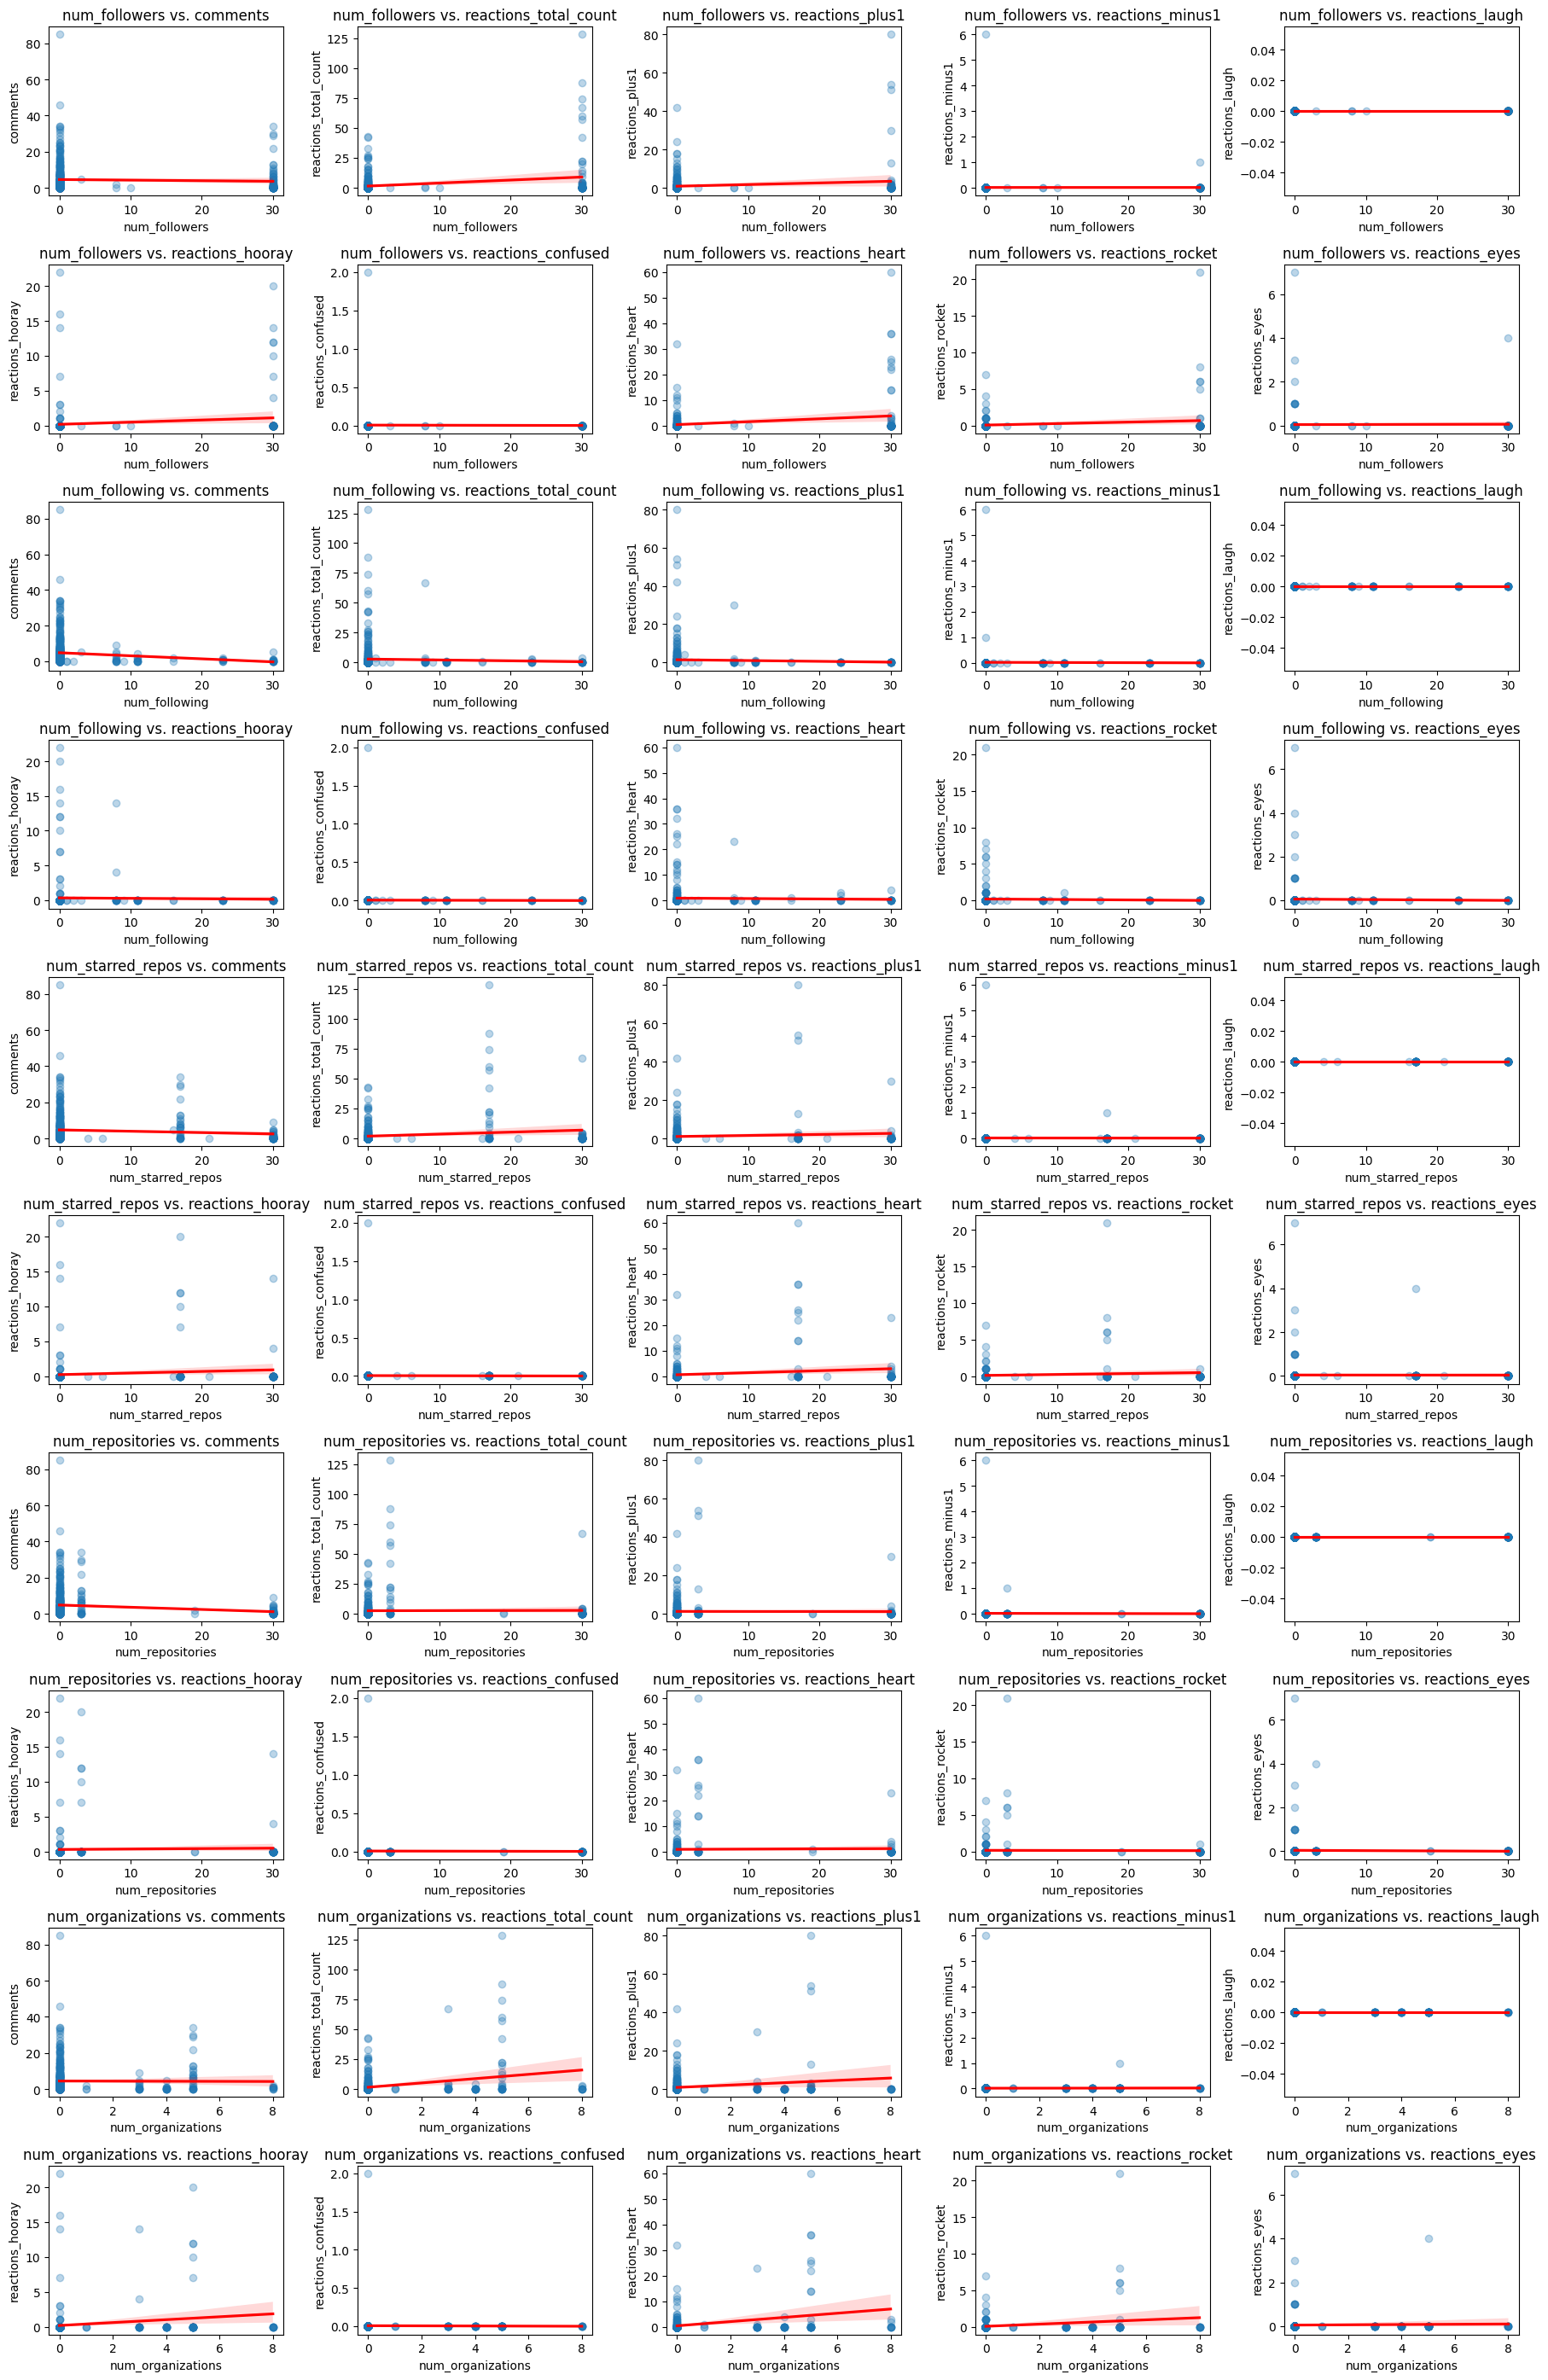

In [58]:
engagement_metrics = ['comments', 'reactions_total_count', 'reactions_plus1', 'reactions_minus1', 'reactions_laugh',
                    'reactions_hooray', 'reactions_confused', 'reactions_heart', 'reactions_rocket', 'reactions_eyes']

plt.figure(figsize=(18, 28))

for i, user_metric in enumerate(user_metrics):
    for j, engagement_metric in enumerate(engagement_metrics):
        plt.subplot(10, 5, i*10 + j + 1)
        sns.regplot(x=user_metric, y=engagement_metric, data=combined_df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
        plt.title(f'{user_metric} vs. {engagement_metric}')
        plt.xlabel(user_metric)
        plt.ylabel(engagement_metric)

plt.tight_layout()
plt.show()

In [65]:
from statsmodels.formula.api import ols

results = []
for user_metric in user_metrics:
    for engagement_metric in engagement_metrics:
        formula = f'{user_metric} ~ {engagement_metric}'
        model = ols(formula, data=combined_df).fit()
        # Storing user metric, engagement metric, slope, and p-value
        results.append({
            'User Metric': user_metric,
            'Engagement': engagement_metric,
            'Slope': model.params[1],
            'P-Value': model.pvalues[1]
        })

results_df = pd.DataFrame(results)
pivot_df = results_df.pivot(index='Engagement', columns='User Metric', values='Slope')
pivot_df

User Metric,num_followers,num_following,num_organizations,num_repositories,num_starred_repos
Engagement,,,,,
comments,-0.065210,-0.116265,-0.001500,-0.177867,-0.118004
reactions_confused,-2.193387,-0.889780,-0.286573,-1.586172,-1.915832
reactions_eyes,0.341728,-0.454176,0.097275,-0.663509,-0.149833
reactions_heart,0.599938,-0.029178,0.102771,0.037071,0.329336
reactions_hooray,0.850273,-0.060744,0.135583,0.123127,0.497965
reactions_laugh,0.000000,0.000000,0.000000,0.000000,0.000000
reactions_minus1,-0.017506,-0.336892,0.026990,-0.519267,-0.264701
reactions_plus1,0.280337,-0.047225,0.047463,-0.008509,0.140191
reactions_rocket,1.642001,-0.173883,0.283207,-0.088105,0.805825


In [67]:
pivot_p_values = results_df.pivot(index='Engagement', columns='User Metric', values='P-Value')
pivot_p_values

User Metric,num_followers,num_following,num_organizations,num_repositories,num_starred_repos
Engagement,,,,,
comments,3.053006e-01,0.001588,8.781604e-01,0.000942,0.036678
reactions_confused,6.780496e-01,0.772072,7.242245e-01,0.723861,0.683495
reactions_eyes,7.692732e-01,0.502398,5.869775e-01,0.502598,0.885023
reactions_heart,3.440852e-09,0.627062,3.748453e-11,0.672785,0.000309
reactions_hooray,2.734298e-04,0.656817,1.587514e-04,0.537738,0.016967
reactions_laugh,NaN,NaN,NaN,NaN,NaN
reactions_minus1,9.919634e-01,0.738788,9.195304e-01,0.725096,0.864025
reactions_plus1,5.200395e-04,0.317300,1.297100e-04,0.901931,0.051994
reactions_rocket,4.186451e-05,0.459146,4.085962e-06,0.797516,0.024610


: 

When a user follows more people, it usually leads to less engagement overall. This means that users with a high number of people they follow have a lower attention or value of their interactions.
Regarding comments, as users' metrics increase, the number of comments they get tends to go down. This might mean that well-known users receive fewer, but more useful comments that focus on quality rather than quantity. This is important because it shows that the community gives more thoughtful attention to active users.